In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# Define model parameters
alpha = 0.75  # 3/4 per year
beta_no_damage = 0
gamma_no_damage = 0
beta_severe = 1 / 4   
gamma_severe = 1 / 8  
beta_unrealistic = 4 
gamma_unrealistic = 2  
rho = 1 / 100  # mm/yr, Laplacian rate constant

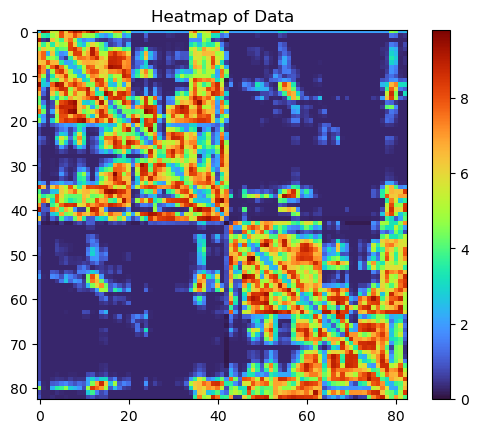

In [3]:
weight_filename = "extended_weights.npy"
mapping_filename = "gdrive/MyDrive/PBM-report2/Categorized_Brain_Nodes.csv"
fiber_length_filename = "gdrive/MyDrive/PBM-report2/LengthFibers33.dat"

w_kj = np.load(weight_filename)
num_nodes = w_kj.shape[0]

# Plot the heatmap using matplotlib
plt.imshow(w_kj, cmap='turbo', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of Data')
plt.show()

In [4]:
# Define the differential equation model
def dcdt(c_k, q_k, w_kj, alpha):
    # Define the graph Laplacian matrix L
    D = np.diag(w_kj.sum(axis=1))
    L = rho * (D - w_kj)
    return -L.dot(c_k) + alpha * c_k * (1 - c_k)

def dqdt(c_k, q_k, beta):
    return beta * c_k * (1 - q_k)

def dwdt(w_kj, q_k, gamma):
    q_sum = q_k[:, None] + q_k  # Calculate the sum of damage
    return -gamma * w_kj * q_sum

# Integrate the model equations
def model(y, t, beta, gamma):
    num_variables = 2 * num_nodes + num_nodes**2
    c_k = y[:num_nodes]
    q_k = y[num_nodes:2*num_nodes]
    w_kj = y[2*num_nodes:num_variables].reshape((num_nodes, num_nodes))

    # Calculate dc/dt, dq/dt, dw/dt
    dc_dt = dcdt(c_k, q_k, w_kj, alpha)
    dq_dt = dqdt(c_k, q_k, beta)
    dw_dt = dwdt(w_kj, q_k, gamma).flatten()

    # Merge them back into a flat array
    dydt = np.concatenate((dc_dt, dq_dt, dw_dt))
    return dydt

In [6]:
# Initialize c_k (toxic protein concentration), q_k (node damage), and w_kj (edge weight)
c_k = np.zeros(num_nodes)
q_k = np.zeros(num_nodes)

# Assume that the node indexes corresponding to the medial frontal area are 26 and 68
entorhinal_nodes = [26, 68]
seed_protein_concentration = 0.025
for entorhinal_node in entorhinal_nodes:
    c_k[entorhinal_node] = seed_protein_concentration

In [7]:
c_k

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.025,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.025, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ])

In [8]:
# Set the time points
t = np.linspace(0, 30, 1000) # From 0 to 30 years, a total of 1000 time points

# Set initial conditions
y0 = np.concatenate((c_k, q_k, w_kj.flatten()))

# No damage (β=γ=0)
sol_no_damage = odeint(model, y0, t, args=(beta_no_damage, gamma_no_damage))
c_k_no_damage = sol_no_damage[:, :num_nodes]
C_T_no_damage = c_k_no_damage.mean(axis=1)


# Severe damage (β=1/4, γ=1/8)
sol_severe = odeint(model, y0, t, args=(beta_severe, gamma_severe))
c_k_severe = sol_severe[:, :num_nodes]
q_k_severe = sol_severe[:, num_nodes:2*num_nodes]
w_kj_severe = sol_severe[:, 2*num_nodes:].reshape((len(t), num_nodes, num_nodes))
C_T_severe = c_k_severe.mean(axis=1)
Q_severe = q_k_severe.mean(axis=1)
W_severe = np.array([np.linalg.norm(w) / np.linalg.norm(w_kj) for w in w_kj_severe])


# unrealistic damage (β=4, γ=2)
sol_unrealistic = odeint(model, y0, t, args=(beta_unrealistic, gamma_unrealistic))
c_k_unrealistic = sol_unrealistic[:, :num_nodes]
q_k_unrealistic = sol_unrealistic[:, num_nodes:2*num_nodes]
w_kj_unrealistic = sol_unrealistic[:, 2*num_nodes:].reshape((len(t), num_nodes, num_nodes))
C_T_unrealistic = c_k_unrealistic.mean(axis=1)
Q_unrealistic = q_k_unrealistic.mean(axis=1)
W_unrealistic = np.array([np.linalg.norm(w) / np.linalg.norm(w_kj) for w in w_kj_unrealistic])

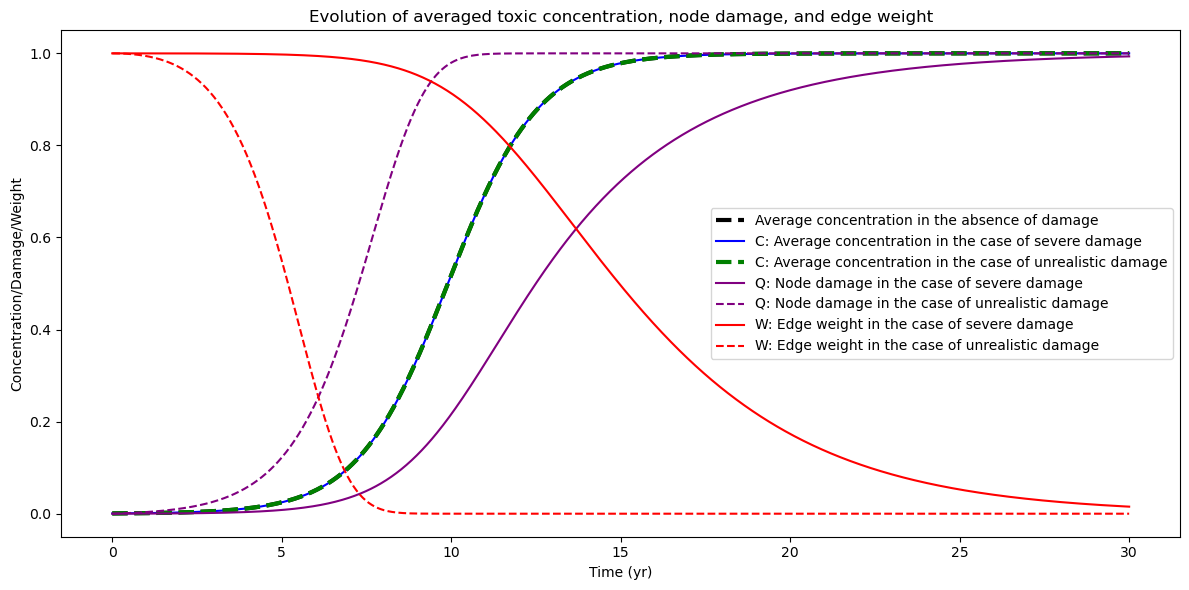

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(t, C_T_no_damage, 'black', linestyle="--",linewidth=3, label='Average concentration in the absence of damage')
plt.plot(t, C_T_severe, 'b-', label='C: Average concentration in the case of severe damage')
plt.plot(t, C_T_unrealistic, 'g--',linewidth=3, label='C: Average concentration in the case of unrealistic damage')
plt.plot(t, Q_severe, color="purple", label='Q: Node damage in the case of severe damage')
plt.plot(t, Q_unrealistic, color="purple", linestyle="--", label='Q: Node damage in the case of unrealistic damage')
plt.plot(t, W_severe, 'r-', label='W: Edge weight in the case of severe damage')
plt.plot(t, W_unrealistic, 'r--', label='W: Edge weight in the case of unrealistic damage')
plt.title('Evolution of averaged toxic concentration, node damage, and edge weight')
plt.xlabel('Time (yr)')
plt.ylabel('Concentration/Damage/Weight')
plt.legend()
plt.tight_layout()